In [70]:
#40変数L96 完全モデル・完全観測でのETKSによるパラメータ推定
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import random


[7227.00000011 7227.05000011 7227.10000011 ... 7299.90000011 7299.95000011
 7300.00000011]


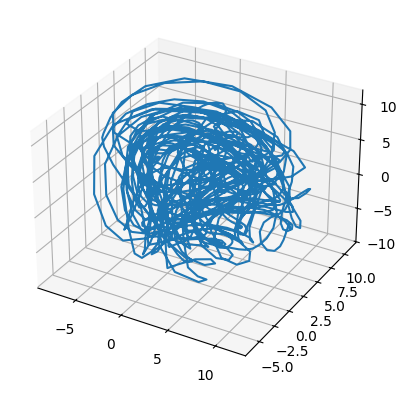

In [71]:
# Simulation parameters
t0 = 0.0 #初期時刻
dt = 1.e-2 #時間刻み幅
obs_interval = 5 #観測間隔(6hに相当するよう設定), 5なら5*dtごとに観測
n_timestep = obs_interval * 4 * 365  # 合計タイムステップ(1year)
n_data = n_timestep // obs_interval  #観測データの個数
L=16 #スムーザーの同化窓の長さ(単位:obs_interval)
n_assim = n_data
m = 40#8  #モデル変数の数
n_param = 1 #推定するパラメータの数
len_x = m + n_param#状態変数の長さ
len_obs = 40 #観測数
F_ex = 8.
k = 40 #アンサンブルメンバー数

#Assimilation parameters
rho=1.0 #Multiplicative inflation
alpha =0.25 #RTPS
alpha_param = 1. #RTPS(parameter)

# Generate observation data by adding noise to true data
rng = np.random.default_rng(2357) #シードを固定


# Load binary data for true values
with open("1scalePlusSine_t_truedata_fort_50span.bin", "rb") as f_t:
    data_time = np.frombuffer(f_t.read(), dtype=np.float64)
data_time = np.append(data_time[0] + (data_time[0] -data_time[1]), data_time)
print(data_time)


# with open("1scale_xtrue_timeseries_km40_F8_50span.bin", "rb") as f_x1:
with open("1scalePlusSine_xtrue_timeseries_km40_F8_50span.bin", "rb") as f_x1: #不完全モデル
    true_data_x = np.frombuffer(f_x1.read(), dtype=np.float64)

true_data_x = true_data_x.reshape((n_data, m))

fig = plt.figure()
ax=fig.add_subplot(111, projection='3d')
# ax.plot(true_data_x[:,k//3],true_data_x[:,k//3 *2],true_data_x[:,-1])
# ax.plot(true_data_x[:,-3],true_data_x[:,-2],true_data_x[:,-1])
ax.plot(true_data_x[:,3],true_data_x[:,2],true_data_x[:,1])


In [72]:
@njit(cache=True)
def model_forecast_pe(t, X, F_ex, param):
    """
    L96モデルのdX/dtを計算する関数。(n_param-1)次式でモデル誤差を修正

    Parameters:
        t:時刻
        X:モデル変数
        F_ex:外力
        param:推定パラメータ

    Returns:
        model (numpy.ndarray): dX/dtの配列
    """

    mm = len(X)
    n_param = len(param)     # 推定パラメータ

    model = np.empty(mm)
    for k in range(mm):
        # X[k] の 0次〜(n_param-1)次の項
        estim = 0.0
        i = 0
        for i in range(n_param):
            estim += param[i] * X[k]**i

        model[k] = X[(k - 1) % mm] * (X[(k + 1) % mm] - X[(k - 2) % mm]) - X[k] + F_ex + estim

    return model


# @njit(cache=True)
# def model_forecast(t, X, F_ex):
#     """
#     L96モデルのdX/dtを計算する関数。

#     Parameters:
#         t:時刻
#         X:モデル変数
#         F_ex:外力

#     Returns:
#         model (numpy.ndarray): dX/dtの配列
#     """
#     mm = len(X)
#     model = np.empty(mm)  # Initialize the model array
#     for a in range(mm):
#         model[a] =  X[(a - 1) % mm] * (X[(a + 1) % mm] - X[(a - 2) % mm]) - X[a] + F_ex
#     return model


@njit(cache=True)
def RK4(t,model, y0, dt, steps, *model_args):
    """
    4次のルンゲクッタ法で微分方程式を数値積分する汎用関数。

    Parameters:
        model (function): 微分方程式モデル f(t, y, *args) を指定。
                          t (float): 現在の時間
                          y (array-like): 現在の状態ベクトル
                          *args: モデルに渡す追加の引数
        y0 (array-like): 初期状態ベクトル
        dt (float): 時間刻み幅
        steps (int): 積分するステップ数
        *model_args: モデルに渡す追加の引数（任意）

    Returns:
        # t (numpy.ndarray): 時間の配列
        y (numpy.ndarray): 時間発展後の状態ベクトル
    """
    y = y0
    t = t0

    for step in range(steps):
        k1 = dt * model(t, y, *model_args)
        k2 = dt * model(t + dt / 2, y + k1 / 2, *model_args)
        k3 = dt * model(t + dt / 2, y + k2 / 2, *model_args)
        k4 = dt * model(t + dt, y + k3, *model_args)

        y = y + (k1 + 2 * k2 + 2 * k3 + k4) / 6
        t = t + dt
    return  y

@njit(cache=True)
def compute_R_atr(true_data):
    """
    アトラクタ半径を数値的に求める関数。
    Parameter:
        true_data:アトラクタ半径(状態空間上)を求めたい状態変数の配列(時間数, 成分数)

    Return:
        R_atr:アトラクタ半径
    """
    n = true_data.shape[0] #時間方向に何個データあるか
    R_atr = 0.0
    for k in range(n):
        for l in range(k + 1, n):  # l_listに相当
            diff = true_data[k] - true_data[l]
            R_atr += np.sqrt(np.sum(diff ** 2))
    R_atr = R_atr * 2.0 / (n * (n - 1))
    return R_atr




# @njit(cache=True)
def ETKF(fcst, H, R, obs):
    """
    (L)ETKF(Hunt et al,2007)の解析ステップを計算する関数。
    Parameters:
        fcst:観測データ同化前の予報アンサンブル。x^b_nに相当(状態変数の成分数, アンサンブル数)
        H: 観測行列(観測数, 状態変数の成分数)
        R: 観測誤差共分散行列(観測数, 観測数)
        obs: 観測数
    """
    n_state = fcst.shape[0] #状態変数の成分数
    n_ens = fcst.shape[1] #アンサンブル数
    n_obs = H.shape[0] #観測数

    d_fcst = np.empty((n_state, n_ens)) #X^bに相当
    d_obs = np.empty((n_obs, n_ens)) #Y^bに相当

    fcst_bar = np.mean(fcst, axis=1) #x^bのアンサンブル平均

    #STEP1~2: compute X^b & Y^b
    for e in range(n_ens):
        d_fcst[:,e] = (fcst[:,e] - fcst_bar)
        d_obs[:,e] = H @ d_fcst[:,e]  #(観測数,アンサンブル数) linear observationを仮定

    #STEP3: localization

    #STEP4
    C = d_obs.T @ np.linalg.inv(R) #(観測数,アンサンブル数).T@(観測数,観測数)→(アンサンブル数,観測数)

    #STEP5
    l,U = np.linalg.eig((((n_ens-1) /rho) * np.identity(n_ens)) + C @ d_obs)
    l= np.real(l)
    U = np.real(U)
    D_1 = np.diag(l**-1.)
    Pa_tild = (U @ D_1 @ U.T)  #P~a = UD^(-1)U.T

    #STEP6
    D_2 = np.diag(np.sqrt(1./l))#ｌ^-0.5を対角成分にもつ行列D^-0.5の生成
    Wa =  U @ D_2 @U.T * (n_ens-1)**0.5   #いわゆるT(変換行列)
    d_anls = d_fcst @ Wa #X^a_nに相当

    #STEP7
    wbar_a = Pa_tild @ C @(obs- H @ fcst_bar) #(m,m)@(m,km)@(km,1) = (m,1)

    #STEP8
    e=0
    anls = np.empty_like(fcst) #x^a_nに相当
    for e in range(n_ens):
        Wa[:,e] += wbar_a
        # anls[:,e] = fcst[:,e] + d_fcst @ dWa[:,e]
        anls[:,e] = fcst_bar + d_fcst @ Wa[:,e]

    #STEP9(Localizationありの時)


    return fcst_bar, d_fcst, d_anls, anls

# @njit(cache=True)
def ETKS(fcst, H, R, obs, anls_lag):
    """
    アンサンブルカルマンスムーザーの解析ステップを計算する関数。
    Parameters:
        fcst:観測データ同化前の予報アンサンブル。x^b_nに相当(状態変数の成分数, アンサンブル数)
        H: 観測行列(観測数, 状態変数の成分数)
        R: 観測誤差共分散行列(観測数, 観測数)
        obs: 観測データ
        anls_lag: 解析値T-Ldt～TのL個の解析アンサンブルの配列(ラグ長, 状態変数の成分数, アンサンブル数)

    Returuns:
        fcst_bar: 予報アンサンブルの平均値。(状態変数の成分数, )
        d_fcst: 予報アンサンブルの摂動。(状態変数の成分数, アンサンブル数)
        smoothed_anls: スムーザーを掛けた後の解析アンサンブル (ラグ長, 状態変数の成分数, アンサンブル数)
        smoothed_d_anls
    """
    L = anls_lag.shape[0] #ラグ長
    n_state = fcst.shape[0] #状態変数の成分数
    n_ens = fcst.shape[1] #アンサンブル数
    n_obs = H.shape[0] #観測数

    d_fcst = np.empty((n_state, n_ens)) #X^bに相当
    d_obs = np.empty((n_obs, n_ens)) #Y^bに相当

    fcst_bar = np.mean(fcst, axis=1) #x^bのアンサンブル平均

    #STEP1~2: compute X^b & Y^b
    for e in range(n_ens):
        d_fcst[:,e] = (fcst[:,e] - fcst_bar)
        d_obs[:,e] = H @ d_fcst[:,e]  #(観測数,アンサンブル数) linear observationを仮定

    #STEP4
    C = d_obs.T @ np.linalg.inv(R) #(観測数,アンサンブル数).T@(観測数,観測数)→(アンサンブル数,観測数)

    #STEP5
    l,U = np.linalg.eig((((n_ens-1) /rho) * np.identity(n_ens)) + C @ d_obs)
    l= np.real(l)
    U = np.real(U)
    D_1 = np.diag(l**-1.)
    Pa_tild = (U @ D_1 @ U.T)  #P~a = UD^(-1)U.T

    #STEP6
    D_2 = np.diag(np.sqrt(1./l))#ｌ^-0.5を対角成分にもつ行列D^-0.5の生成
    Wa =  U @ D_2 @U.T * (n_ens-1)**0.5   #いわゆるT(変換行列)
    d_anls = d_fcst @ Wa #X^a_nに相当

    #STEP7
    wbar_a = Pa_tild @ C @(obs- H @ fcst_bar) #(m,m)@(m,km)@(km,1) = (m,1)

    #STEP8
    e=0
    anls = np.empty_like(fcst) #x^a_nに相当
    for e in range(n_ens):
        Wa[:,e] += wbar_a
        # anls[:,e] = fcst[:,e] + d_fcst @ dWa[:,e]
        anls[:,e] = fcst_bar + d_fcst @ Wa[:,e]

    #STEP9(Localizationありの時)


    #Smoothing
    smoothed_anls = np.empty_like(anls_lag)
    smoothed_d_anls = np.empty_like(anls_lag)

    # 最後の時刻はそのまま
    smoothed_anls[-1] = anls
    smoothed_d_anls[-1] = d_anls

    # 後ろから前に遡ってスムージング
    anls_bar = np.mean(anls_lag, axis=2)
    for ll in range(1, L):
        # 解析アンサンブル平均と摂動

        d_anls_l = anls_lag[ll] -anls_bar[ll][:, None]

        # スムーザーゲイン
        P_af =  (d_anls_l @ d_fcst.T)/(n_ens-1)

        S = P_af @ H.T @ np.linalg.inv(R + H @ d_fcst @ d_fcst.T/(n_ens-1) @ H.T)

        # スムージング
        e=0
        for e in range(n_ens):
            anls_lag[ll,:,e] += S @ (obs  - H @ fcst[:,e])
#更新
    smoothed_anls[:-1] = anls_lag[1:]
    smoothed_d_anls[:-1] = anls_lag[1:] - np.mean(anls_lag[1:], axis=2)[:,:,None]

    # スムージング結果を返す
    return fcst_bar, d_fcst, smoothed_anls, smoothed_d_anls

In [73]:
# Identity matrices for H and R
H = np.zeros((len_obs, len_x)) #完全観測(観測数＝状態変数の数)
for i in range(len_obs):
    H[i,i] = 1.


R = np.identity(len_obs)


# Analysis and forecast data arrays
analysis_data = np.zeros((n_data+1, len_x)) #(時系列数, 成分数)
forecast_data = np.zeros((n_data+1, len_x))


In [74]:
#アトラクタ上の値から解析アンサンブルの初期値を出す
with open("1scale_x_initial_km40_F8.bin", "rb") as i_x1:
    init_data = np.frombuffer(i_x1.read(), dtype=np.float64)

n_init = 1000
init_data = init_data.reshape((n_init,m))

print('init_data', init_data.shape)

R_atr = compute_R_atr(init_data)

print('R_atr=',R_atr)
analysis = np.empty((len_x,k))
forecast = np.empty((len_x, k))


#初期ensambleの作成
init_idx = list(np.arange(0,n_init)) #解析値の初期値(t=-dt*assim_step)を選ぶ為の配列

random.seed(1234)
random.shuffle(init_idx)
print('initial indices for analyzed',init_idx[:k])


ens=0
for ens in range(k):
    random_idx_anls = init_idx[ens]
    analysis[:m,ens] = init_data[random_idx_anls,:] #use climatology as initial ensamble
    j=0
    for j in range(n_param):
        analysis[m+j,ens] = (-0.5 + ens/(k-1)) *1. #-0.5~0.5に等間隔に配置
        # analysis[m+j,ens] = rng.standard_normal(1) #
    # analyzed[:,ens] = obs_data[0,:] +rng.standard_normal(len_x) #use t0's data as inital ensamble
forecast = analysis   #プロットのために便宜上設定


analysis_data[0,:] = np.mean(analysis,axis=1)
forecast_data[0, :] = np.mean(forecast,axis=1)


# Trace arrays
trace_P_a = np.zeros(n_assim+1)
trace_P_f = np.zeros(n_assim+1)
spread_model = np.zeros(n_assim+1)
spread_param = np.zeros(n_assim+1)


P_a = np.identity(len_x) * R_atr
P_f = np.identity(len_x) * R_atr

trace_P_a[0] = np.trace(P_a)
spread_model[0] = np.mean([np.linalg.norm(analysis[:m,_]-analysis_data[0,:m] )for _ in range(k)])/m**0.5
spread_param[0] =np.mean([np.linalg.norm(analysis[m:,_]-analysis_data[0,m:] )for _ in range(k)])/n_param**0.5
trace_P_f[0] = np.trace(P_f)


assim_time = np.zeros(n_assim+1)
assim_time[0] = data_time[0] #同化サイクルの時間経過を記録



true_data =np.empty((n_data+1, m) )
true_data[0] = init_data[-1]
true_data[1:] = true_data_x
obs_data_x = true_data+ rng.standard_normal((n_data+1, len_obs))


init_data (1000, 40)
R_atr= 31.494869003146977
initial indices for analyzed [np.int64(56), np.int64(306), np.int64(558), np.int64(770), np.int64(733), np.int64(654), np.int64(957), np.int64(566), np.int64(505), np.int64(823), np.int64(914), np.int64(963), np.int64(374), np.int64(493), np.int64(258), np.int64(325), np.int64(44), np.int64(618), np.int64(428), np.int64(314), np.int64(543), np.int64(382), np.int64(908), np.int64(11), np.int64(412), np.int64(525), np.int64(271), np.int64(297), np.int64(344), np.int64(6), np.int64(183), np.int64(323), np.int64(59), np.int64(313), np.int64(473), np.int64(184), np.int64(403), np.int64(886), np.int64(245), np.int64(335)]


In [75]:
analysis_lag = np.zeros((L, len_x, k))


# Main loop for assimilation
for i in range(1, n_assim+1):
    # 予報ステップ(i-1回目の同化の解析値からi回目の予報値を計算)
    e=0
    for e in range(k):
        forecast[:m,e] = RK4(assim_time[i-1] , model_forecast_pe, analysis[:m,e], dt, obs_interval, F_ex, analysis[m:,e]) #モデル変数を時間発展

    forecast[m:,:] = analysis[m:,:]

    forecast_bar, d_forecast, analysis_lag, d_analysis_lag = ETKS(forecast, H, R, obs_data_x[i], analysis_lag)

    d_analysis = d_analysis_lag[-1]


    # 予報・解析値の記録
    forecast_data[i] = forecast_bar
    if i >= L-1:
        analysis_data[i-L+1:i+1] = np.mean(analysis_lag, axis=2)
    else:
        analysis_data[i] = np.mean(analysis_lag[-1], axis=1)


    #RTPS
    n=0.
    for n in range(len_x):
        if n <m:
            d_analysis[n,:] *= 1.- alpha + alpha * np.linalg.norm(d_forecast[n,:])/np.linalg.norm(d_analysis[n,:])
        else:
             d_analysis[n,:] *= 1.- alpha_param + alpha_param * np.linalg.norm(d_forecast[n,:])/np.linalg.norm(d_analysis[n, :])
    analysis = analysis_data[i][:, None] + d_analysis



    P_f = d_forecast @ d_forecast.T/(k-1)
    P_a = d_analysis @ d_analysis.T/(k-1) #ここ?
    trace_P_f[i] = np.trace(P_f)
    trace_P_a[i] = np.trace(P_a) #Pa = Xb @Pa_tild @ Xb.T
    spread_model[i] = np.mean([np.linalg.norm(analysis[:m,_]-analysis_data[i,:m] )for _ in range(k)])/m**0.5
    spread_param[i] = np.mean([np.linalg.norm(analysis[m:,_]-analysis_data[i,m:] )for _ in range(k)])/n_param**0.5


    assim_time[i] = assim_time[i-1] + dt * obs_interval


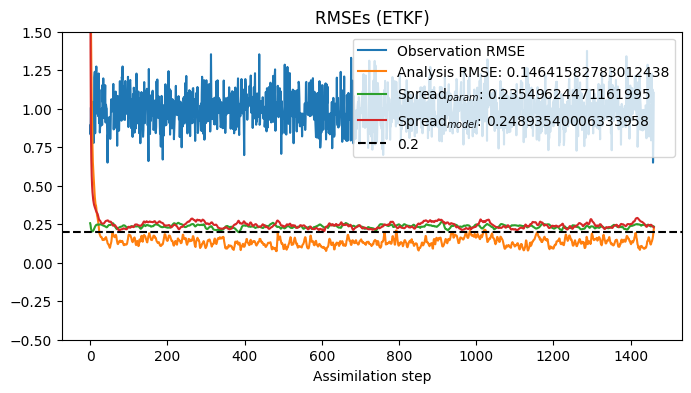

0.137285446240413


In [76]:
# Compute RMSE
RMSE_obs_x1 = np.linalg.norm(obs_data_x[:,:m] - true_data[:,:m], axis=1) / m ** 0.5
RMSE_forecast_x1 = np.linalg.norm(forecast_data[:,:m] - true_data[:,:m], axis=1) / m ** 0.5
RMSE_analysis_x1 = np.linalg.norm(analysis_data[:,:m] - true_data[:,:m], axis=1) / m ** 0.5

# Plot results
fig1=plt.figure(figsize=(8,4))
ax1 = fig1.add_subplot(111)
ax1.plot((data_time-data_time[0])/(dt*obs_interval), RMSE_obs_x1, label="Observation RMSE")
# ax1.plot((data_time-assim_time[0])/(dt*obs_interval), RMSE_forecast_x1, label="Forecast RMSE: "+str(np.mean(RMSE_forecast_x1)))
ax1.plot((data_time-assim_time[0])/(dt*obs_interval), RMSE_analysis_x1, label="Analysis RMSE: "+str(np.mean(RMSE_analysis_x1)), alpha=1.)
ax1.plot((data_time-assim_time[0])/(dt*obs_interval), spread_param, label='Spread$_{param}$: '+str(np.mean(spread_param)))
ax1.plot((data_time-assim_time[0])/(dt*obs_interval), spread_model, label='Spread$_{model}$: '+str(np.mean(spread_model)))

ax1.axhline(0.2, color='k', linestyle='--', label="0.2")

ax1.set_xlabel("Assimilation step")
ax1.set_ylim((-0.5,1.5))
ax1.legend()
ax1.set_title('RMSEs (ETKF)')

plt.show()
print(np.mean(RMSE_analysis_x1[1000:]))

In [77]:
analysis_data.shape

(1461, 41)

In [78]:
params =analysis_data[:,-n_param:]
F_val_change = params[:,0]

Est_F = F_val_change+F_ex
True_F =  8*np.ones(n_data+1)+np.sin(data_time)

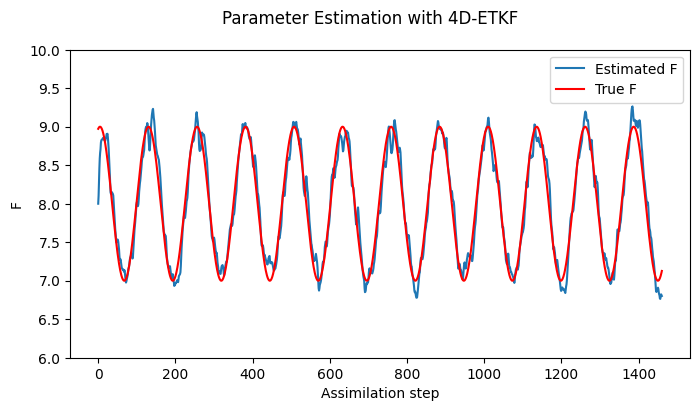

In [79]:
# Plot results
fig1=plt.figure(figsize=(8,4))
ax1 = fig1.add_subplot(111)
# spread=(trace_P_a/(m-1))**0.5
ax1.plot((data_time-data_time[0])/(dt*obs_interval), Est_F, label="Estimated F")
# ax1.plot((data_time-data_time[0])/(dt*assimilation_interval), 8*np.ones(n_data),
# label="True F", color='red')
ax1.plot((data_time-data_time[0])/(dt*obs_interval),True_F,
label="True F", color='red')


# ax1.axhline(8., , linestyle='--', label="8.0", alpha=0.7)

ax1.set_xlabel("Assimilation step")
ax1.set_ylabel("F")

ax1.legend()
ax1.set_ylim((6,10))
fig1.suptitle('Parameter Estimation with 4D-ETKF')
plt.show()

In [80]:
data_time

array([7227.00000011, 7227.05000011, 7227.10000011, ..., 7299.90000011,
       7299.95000011, 7300.00000011])